# Example to test the use of xarray/dask/xgcm with CROCO files (regular or xios):

#########################

In [138]:
%load_ext memory_profiler

import xarray as xr
import numpy as np

#import xroms
from xgcm import Grid

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

%matplotlib inline

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [139]:
# Functions to adapt croco outputs to xgcm
##########################################

def adjust_coords(ds):

    if 'nav_lon_u' not in ds.coords:
        ##########################
        # for regular CROCO files:
        ds = ds.set_coords([c for c in ds.variables if 'lon' in c or 'lat' in c ])

    else:
        ##########################
        # for XIOS files:
        
        ds = ds.rename({'time_counter': 'time'})
        
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])

        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})

        # change axis names to xi,eta (instead of x,y)
        _dims = (d for d in ['x_u', 'x_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'xi' + d[1:]}) 

        _dims = (d for d in ['y_v', 'y_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'eta' + d[1:]}) 


        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 

        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','lat').replace('nav_lon','lon')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='deg', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )

    ##########################
    # For all types  
    if 'eta_psi' in ds.dims: ds = ds.rename({'eta_psi': 'eta_v'}) 
    if 'xi_psi' in ds.dims: ds = ds.rename({'xi_psi': 'xi_u'}) 
        

    ##########################
    # Create xgcm grid
    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
            'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
            's':{'center':'s_rho', 'outer':'s_w'}}

    ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords, periodic=[])


    return ds

    
def add_grd(ds,grd):
    
    ##########################
    for variable in grd.data_vars.keys():
        #print(variable)
        ds[variable] = grd[variable]
        
    ds['mask_rho'] = ds.mask_rho.where(ds.mask_rho>0,np.nan)
    
    if 'lon_psi' not in ds.coords: 
        #ds['lon_psi'] = grd['lon_psi']
        #ds['lat_psi'] = grd['lat_psi']
        ds = ds.assign_coords({'lon_psi':grd['lon_psi'], 'lat_psi':grd['lat_psi']})

    return ds
 
    ########
    

        
        
        

In [140]:
# Dask cluster 

from dask.distributed import Client

client = Client("tcp://127.0.0.1:39241")
client

/home/gula/.virtualenvs/croco36/lib/python3.6/site-packages/distributed/client.py:1129: VersionMismatchWarning: Mismatched versions found

+-------------+--------+-----------+-----------+
| Package     | client | scheduler | workers   |
+-------------+--------+-----------+-----------+
| dask        | 2.30.0 | 2020.12.0 | 2020.12.0 |
| distributed | 2.30.0 | 2020.12.0 | 2020.12.0 |
| msgpack     | 1.0.0  | 1.0.1     | 1.0.1     |
| numpy       | 1.19.2 | 1.18.4    | 1.18.4    |
| tornado     | 6.0.4  | 6.1       | 6.1       |
+-------------+--------+-----------+-----------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://127.0.0.1:39241 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 67.55 GB


In [141]:
%%time

############
# Open files
############

simulname = 'gigatl3' # XIOS outputs
#simulname = 'pacbig' # ROMS outputs
#simulname = 'gigatl1' # CROCO outputs

#######################

if 'gigatl1_surf' in simulname:
    # Gigatl1 (full domain)
    grdfile = '/net/libra/local/tmp/1/gula/ROMS/Simulations/GIGATL/GIGATL1/gigatl1_grd_masked.nc'
    hisfile = '/net/omega/local/tmp/1/gula/GIGATL1/GIGATL1_1h_tides/SURF/gigatl1_surf.2008-05-23.nc'
elif 'gigatl1' in simulname:
    # Gigatl1 (one tile)
    grdfile = '/net/omega/local/tmp/1/gula/GIGATL1/GIGATL1_1h_tides/GRD/gigatl1_grd_masked.7779.nc'
    hisfile = '/net/omega/local/tmp/1/gula/GIGATL1/GIGATL1_1h_tides/AVG/gigatl1_avg.7779.*.nc'
    timename='time'
elif 'gigatl3' in simulname:
    # Gigatl3
    grdfile = '/net/libra/local/tmp/1//gula/ROMS/Simulations/GIGATL/GIGATL3/gigatl3_grd.nc'
    #hisfile = '/net/omega/local/tmp/1/gula/GIGATL3/GIGATL3_1h_tides/SURF/GIGATL3_1h_inst_surf_2008-05-23-2008-05-27.nc'
    hisfile = '/net/omega/local/tmp/1/gula/GIGATL3/GIGATL3_1h/AVG/GIGATL3_5d_aver_20??.mean.nc'
    timename='time_counter'
elif 'pacbig' in simulname:
    # Pacbig
    grdfile='/net/krypton/data0/project/meddle/gula/ROMS/Simulations/PACBIG/pacbig_grd_nw_dig.nc'
    hisfile='/net/krypton/data0/project/meddle/gula/ROMS/Simulations/PACBIG/HIS/pacbig_his.0402.nc'
    timename='time'

#######################
# open dataset
%memit ds = xr.open_mfdataset(hisfile,chunks={timename:1}, concat_dim = timename, combine='nested',\
                        coords="minimal", data_vars="minimal", compat='override')

# open grid file
%memit grd = xr.open_dataset(grdfile)

########

# adjust coords to be consistent with xgcm
%memit ds = adjust_coords(ds)
%memit grd = adjust_coords(grd)

# add grid variables to dataset
%memit ds = add_grd(ds,grd)

#######################
# Create xgcm grid

%memit grid = ds.attrs['xgcm-Grid']

# Turn on chunking to activate dask and parallelize read/write.

%memit ds = ds.chunk({'time': 1, 'xi_rho': 500,'eta_rho': 500 })

ds

peak memory: 2045.71 MiB, increment: 0.00 MiB
peak memory: 2045.71 MiB, increment: 0.00 MiB
peak memory: 2045.71 MiB, increment: 0.00 MiB
peak memory: 2045.71 MiB, increment: 0.00 MiB
peak memory: 2412.46 MiB, increment: 366.76 MiB
peak memory: 2330.75 MiB, increment: 0.00 MiB
peak memory: 2330.75 MiB, increment: 0.00 MiB
CPU times: user 2.86 s, sys: 891 ms, total: 3.75 s
Wall time: 4.88 s


<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, eta_rho: 4002, eta_v: 4001, one: 1, s_rho: 100, s_w: 101, time: 5, xi_rho: 3002, xi_u: 3001)
Coordinates:
    lat_rho               (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lon_rho               (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lat_u                 (eta_rho, xi_u) float32 dask.array<chunksize=(500, 3001), meta=np.ndarray>
    lon_u                 (eta_rho, xi_u) float32 dask.array<chunksize=(500, 3001), meta=np.ndarray>
    lat_v                 (eta_v, xi_rho) float32 dask.array<chunksize=(4001, 500), meta=np.ndarray>
    lon_v                 (eta_v, xi_rho) float32 dask.array<chunksize=(4001, 500), meta=np.ndarray>
  * s_rho                 (s_rho) float32 -0.995 -0.985 -0.975 ... -0.015 -0.005
    lat_w                 (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lon_w                 (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
  * s_w                   (s_w) float32 -1.0 -0.99 -0.98 ... -0.02 -0.01 0.0
    time_centered         (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 2008-07-03T21:13:50.769230720...
    lat_psi               (eta_v, xi_u) float64 dask.array<chunksize=(4001, 3001), meta=np.ndarray>
    lon_psi               (eta_v, xi_u) float64 dask.array<chunksize=(4001, 3001), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds, eta_rho, eta_v, one, xi_rho, xi_u
Data variables:
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    zeta                  (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    ubar                  (time, eta_rho, xi_u) float32 dask.array<chunksize=(1, 500, 3001), meta=np.ndarray>
    vbar                  (time, eta_v, xi_rho) float32 dask.array<chunksize=(1, 4001, 500), meta=np.ndarray>
    sustr                 (time, eta_rho, xi_u) float32 dask.array<chunksize=(1, 500, 3001), meta=np.ndarray>
    svstr                 (time, eta_v, xi_rho) float32 dask.array<chunksize=(1, 4001, 500), meta=np.ndarray>
    u                     (time, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(1, 100, 500, 3001), meta=np.ndarray>
    v                     (time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(1, 100, 4001, 500), meta=np.ndarray>
    w                     (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 500, 500), meta=np.ndarray>
    temp                  (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 500, 500), meta=np.ndarray>
    salt                  (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 500, 500), meta=np.ndarray>
    rho                   (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 500, 500), meta=np.ndarray>
    bvf                   (time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 101, 500, 500), meta=np.ndarray>
    spherical             (one) |S1 dask.array<chunksize=(1,), meta=np.ndarray>
    angle                 (eta_rho, xi_rho) float64 dask.array<chunksize=(500, 500), meta=np.ndarray>
    h                     (eta_rho, xi_rho) float64 dask.array<chunksize=(500, 500), meta=np.ndarray>
    hraw                  (eta_rho, xi_rho) float64 dask.array<chunksize=(500, 500), meta=np.ndarray>
    f                     (eta_rho, xi_rho) float64 dask.array<chunksize=(500, 500), meta=np.ndarray>
    pm                    (eta_rho, xi_rho) float64 dask.array<chunksize=(500, 500), meta=np.ndarray>
    pn                    (eta_rho, xi_rho) float64 dask.array<chunksize=(500, 500), meta=np.ndarray>
    mask_rho              (eta_rho, xi_rho) float64 dask.array<chunksize=(500,

## Add the vertical coordinate

In [142]:
%%time

if ds.VertCoordType=='NEW':
    ds['Vtransform'] = 2
else:
    ds['Vtransform'] = 1
    
#ds.coords['s_rho'] = ds.sc_r
#ds.coords['s_w'] = ds.sc_w

ds['hc'] = 300.
ds['Vtransform'] = 2

#ds['sc_r'] = ds['s_rho']
#ds['sc_w'] = ds['s_w']

ds['Cs_r'] = ds.Cs_r
ds['Cs_w'] = ds.Cs_w

try:
    # needed for older roms files (e.g. pacbig)
    ds['Cs_r'] = ds['Cs_r'].rename({"Cs_r":"s_rho"})
    ds['Cs_w'] = ds['Cs_w'].rename({"Cs_w":"s_w"})
except:
    pass
    
try:
    ds = ds.reset_coords([c for c in ds.coords if 'Cs' in c])
except:
    pass
    
ds['angle'] = ds.angle
ds['mask_rho'] = ds.mask_rho


# Pick out some of the variables that will be included as coordinates
#ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

#####################
# Including vertical coordinates

if ds.Vtransform == 1:
    Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
    z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
elif ds.Vtransform == 2:
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho; del Zo_rho

ds.coords['z_rho'] = z_rho 


if ds.Vtransform == 1:
    Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
    z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
elif ds.Vtransform == 2:
    Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
    z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w; del Zo_w


ds.coords['z_w'] = z_w 

ds

CPU times: user 100 ms, sys: 2.92 ms, total: 103 ms
Wall time: 99.8 ms


<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, eta_rho: 4002, eta_v: 4001, one: 1, s_rho: 100, s_w: 101, time: 5, xi_rho: 3002, xi_u: 3001)
Coordinates:
    lat_rho               (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lon_rho               (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lat_u                 (eta_rho, xi_u) float32 dask.array<chunksize=(500, 3001), meta=np.ndarray>
    lon_u                 (eta_rho, xi_u) float32 dask.array<chunksize=(500, 3001), meta=np.ndarray>
    lat_v                 (eta_v, xi_rho) float32 dask.array<chunksize=(4001, 500), meta=np.ndarray>
    lon_v                 (eta_v, xi_rho) float32 dask.array<chunksize=(4001, 500), meta=np.ndarray>
  * s_rho                 (s_rho) float32 -0.995 -0.985 -0.975 ... -0.015 -0.005
    lat_w                 (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lon_w                 (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
  * s_w                   (s_w) float32 -1.0 -0.99 -0.98 ... -0.02 -0.01 0.0
    time_centered         (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 2008-07-03T21:13:50.769230720...
    lat_psi               (eta_v, xi_u) float64 dask.array<chunksize=(4001, 3001), meta=np.ndarray>
    lon_psi               (eta_v, xi_u) float64 dask.array<chunksize=(4001, 3001), meta=np.ndarray>
    z_rho                 (time, eta_rho, xi_rho, s_rho) float64 dask.array<chunksize=(1, 500, 500, 100), meta=np.ndarray>
    z_w                   (time, eta_rho, xi_rho, s_w) float64 dask.array<chunksize=(1, 500, 500, 101), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds, eta_rho, eta_v, one, xi_rho, xi_u
Data variables:
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    zeta                  (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    ubar                  (time, eta_rho, xi_u) float32 dask.array<chunksize=(1, 500, 3001), meta=np.ndarray>
    vbar                  (time, eta_v, xi_rho) float32 dask.array<chunksize=(1, 4001, 500), meta=np.ndarray>
    sustr                 (time, eta_rho, xi_u) float32 dask.array<chunksize=(1, 500, 3001), meta=np.ndarray>
    svstr                 (time, eta_v, xi_rho) float32 dask.array<chunksize=(1, 4001, 500), meta=np.ndarray>
    u                     (time, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(1, 100, 500, 3001), meta=np.ndarray>
    v                     (time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(1, 100, 4001, 500), meta=np.ndarray>
    w                     (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 500, 500), meta=np.ndarray>
    temp                  (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 500, 500), meta=np.ndarray>
    salt                  (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 500, 500), meta=np.ndarray>
    rho                   (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 500, 500), meta=np.ndarray>
    bvf                   (time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 101, 500, 500), meta=np.ndarray>
    spherical             (one) |S1 dask.array<chunksize=(1,), meta=np.ndarray>
    angle                 (eta_rho, xi_rho) float64 dask.array<chunksize=(500, 500), meta=np.ndarray>
    h                     (eta_rho, xi_rho) float64 dask.array<chunksize=(500, 500), meta=np.ndarray>
    hraw                  (eta_rho, xi_rho) float64 dask.array<chunksize=(500, 500), meta=np.ndarray>
    f                     (eta_rho, xi_rho) float64 dask.array<chunksize=(500, 500), meta=np.ndarray>
    pm                    (eta_rho, xi

## Plot section on sigma-levels

CPU times: user 295 ms, sys: 27.5 ms, total: 322 ms
Wall time: 8.92 s


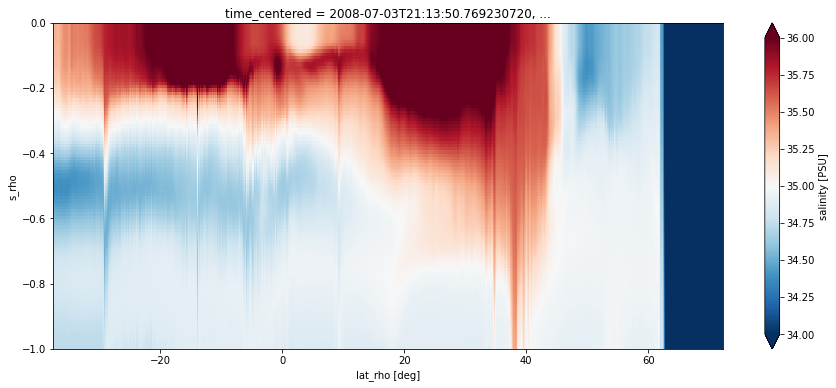

In [143]:
%%time

section = ds.salt.isel(xi_rho=np.int(ds.h.shape[0]/2),  time=0)
section.plot(x='lat_rho', y='s_rho', vmin=34., vmax=36., figsize=(15, 6), cmap = 'RdBu_r')
#plt.ylim([-100, 1]);


## Plot section on z-levels

CPU times: user 321 ms, sys: 12.1 ms, total: 333 ms
Wall time: 8.79 s


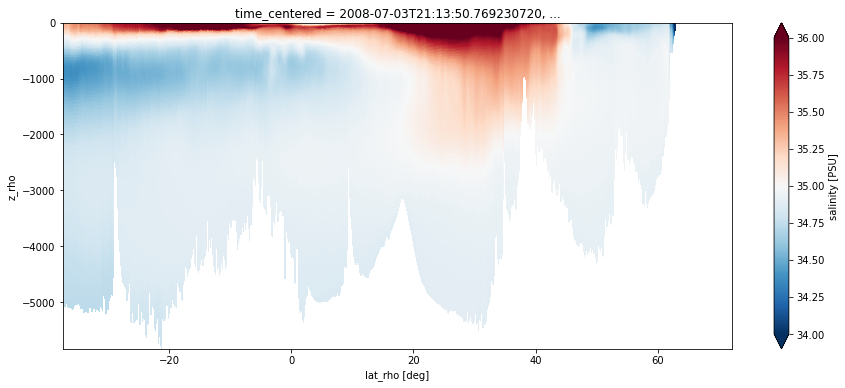

In [144]:
%%time

section = ds.salt.isel(xi_rho=np.int(ds.h.shape[0]/2),  time=0)
section.plot(x='lat_rho', y='z_rho', vmin=34., vmax=36., figsize=(15, 6), cmap = 'RdBu_r')
#plt.ylim([-100, 1]);


# Compute vorticity

In [145]:
%%time

ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'eta'),  'xi') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'xi'),  'eta') # at psi points (eta_v, xi_u)

ds['dudy'] = grid.diff(ds.u, 'eta')*ds['pn_psi']
ds['dvdx'] = grid.diff(ds.v, 'xi')*ds['pm_psi']

ds['f_psi'] = grid.interp(grid.interp(ds.f, 'eta'),  'xi')
ds['mask_psi'] = grid.interp(grid.interp(ds.mask_rho, 'eta'),  'xi') # at psi points (eta_v, xi_u) 

ds['vor'] = ds['dvdx'] - ds['dudy']
ds['rvor'] = ds.vor*ds['mask_psi']/1e-4 #/ds['f_psi'] # normalized vorticity
%memit ds['rvor']

peak memory: 2347.09 MiB, increment: 0.17 MiB
CPU times: user 446 ms, sys: 114 ms, total: 559 ms
Wall time: 736 ms


# Compute mean

In [148]:
%%time

%memit np.nanmean(ds.rvor.isel(time=0))

peak memory: 21836.42 MiB, increment: 19489.32 MiB
CPU times: user 13.9 s, sys: 15.7 s, total: 29.6 s
Wall time: 2min 33s


# Plot vrt

peak memory: 18140.22 MiB, increment: 711.34 MiB
CPU times: user 4.34 s, sys: 1.38 s, total: 5.72 s
Wall time: 2min 19s


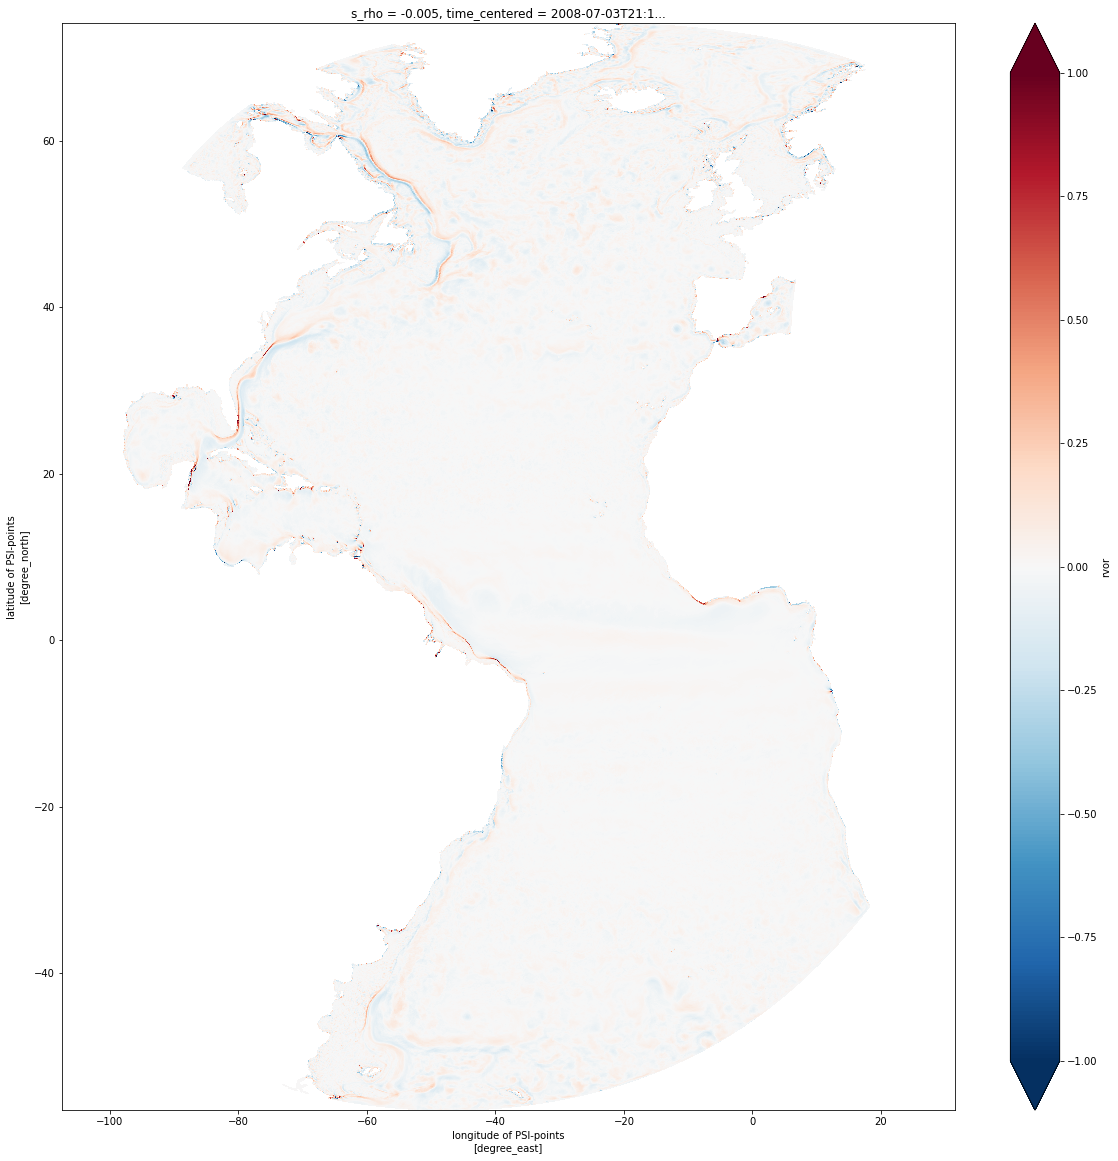

In [151]:
%%time

        
fig = plt.figure(figsize=(20,20))

%memit ds.rvor.isel(time=0, s_rho=-1).plot(x='lon_psi', y='lat_psi',\
                            vmin=-1., vmax=1., cmap='RdBu_r')

#####
